In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time



In [2]:
# Define the Rastrigin function
def rastrigin(X):
    A = 10
    return A * len(X) + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in X])

# Parameters
dimensions = 2
iterations = 100
population_size = 30



In [3]:
# 1. Particle Swarm Optimization (PSO) Implementation
def pso():
    num_particles = population_size
    c1 = 2    # Cognitive coefficient
    c2 = 2    # Social coefficient
    w = 0.7   # Inertia weight

    # Initialize particle positions and velocities
    positions = np.random.uniform(-5.12, 5.12, (num_particles, dimensions))
    velocities = np.random.uniform(-1, 1, (num_particles, dimensions))
    personal_best_positions = positions.copy()
    personal_best_scores = np.array([rastrigin(p) for p in positions])
    global_best_idx = np.argmin(personal_best_scores)
    global_best_position = personal_best_positions[global_best_idx].copy()
    global_best_score = personal_best_scores[global_best_idx]

    pso_best_scores = []
    for i in range(iterations):
        for j in range(num_particles):
            r1, r2 = np.random.rand(2)
            velocities[j] = (w * velocities[j] +
                             c1 * r1 * (personal_best_positions[j] - positions[j]) +
                             c2 * r2 * (global_best_position - positions[j]))
            positions[j] += velocities[j]
            positions[j] = np.clip(positions[j], -5.12, 5.12)
            fitness = rastrigin(positions[j])
            if fitness < personal_best_scores[j]:
                personal_best_scores[j] = fitness
                personal_best_positions[j] = positions[j].copy()
                if fitness < global_best_score:
                    global_best_score = fitness
                    global_best_position = positions[j].copy()
        pso_best_scores.append(global_best_score)
    return pso_best_scores, global_best_position, global_best_score



In [4]:
# 2. Genetic Algorithm (GA) Implementation
def ga():
    crossover_rate = 0.8
    mutation_rate = 0.1
    tournament_size = 3
    lower_bound = -5.12
    upper_bound = 5.12

    population = np.random.uniform(lower_bound, upper_bound, (population_size, dimensions))

    ga_best_scores = []
    for gen in range(iterations):
        fitness_scores = np.array([rastrigin(ind) for ind in population])
        best_idx = np.argmin(fitness_scores)
        best_score = fitness_scores[best_idx]
        ga_best_scores.append(best_score)

        selected = []
        for _ in range(population.shape[0]):
            participants = np.random.choice(population_size, tournament_size, replace=False)
            winner = participants[np.argmin(fitness_scores[participants])]
            selected.append(population[winner])
        selected = np.array(selected)

        next_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected[i], selected[i+1]
            if np.random.rand() < crossover_rate:
                mask = np.random.rand(dimensions) < 0.5
                child1 = np.where(mask, parent1, parent2)
                child2 = np.where(mask, parent2, parent1)
                next_population.extend([child1, child2])
            else:
                next_population.extend([parent1, parent2])

        next_population = np.array(next_population)
        for i in range(population_size):
            for j in range(dimensions):
                if np.random.rand() < mutation_rate:
                    next_population[i, j] += np.random.normal(0, 0.1)
                    next_population[i, j] = np.clip(next_population[i, j], lower_bound, upper_bound)

        population = next_population.copy()

    final_fitness = np.array([rastrigin(ind) for ind in population])
    best_idx = np.argmin(final_fitness)
    return ga_best_scores, population[best_idx], final_fitness[best_idx]




In [24]:
# ACO Parameters
num_ants = 30
iterations = 100
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic value
evaporation_rate = 0.5
Q = 10.0     # Pheromone deposit factor

# Initialize pheromones and best position
pheromones = np.ones((num_ants, dimensions))
best_position = np.random.uniform(-5.12, 5.12, dimensions)
best_score = rastrigin(best_position)

def aco():
    global pheromones, best_position, best_score
    aco_best_scores = []

    for _ in range(iterations):
        all_ants = []
        all_scores = []

        for _ in range(num_ants):
            position = np.zeros(dimensions)
            for d in range(dimensions):
                probabilities = (pheromones[:, d] ** alpha) * ((1.0 / (np.abs(best_position[d]) + 1e-10)) ** beta)
                probabilities /= np.sum(probabilities)
                position[d] = np.random.choice(np.linspace(-5.12, 5.12, num_ants), p=probabilities)

            score = rastrigin(position)
            all_ants.append(position)
            all_scores.append(score)

            if score < best_score:
                best_score = score
                best_position = position

        # Pheromone evaporation
        pheromones *= (1.0 - evaporation_rate)

        # Pheromone deposit
        for i, score in enumerate(all_scores):
            pheromones[i] += Q / (score + 1e-10)  # Small epsilon to avoid division by zero

        aco_best_scores.append(best_score)

    return aco_best_scores, best_position, best_score


In [26]:
# Measure time and run all three algorithms
start_time_pso = time.time()
pso_scores, pso_best_position, pso_best_score = pso()
end_time_pso = time.time()

start_time_ga = time.time()
ga_scores, ga_best_position, ga_best_score = ga()
end_time_ga = time.time()

start_time_aco = time.time()
aco_scores, aco_best_position, aco_best_score = aco()
end_time_aco = time.time()


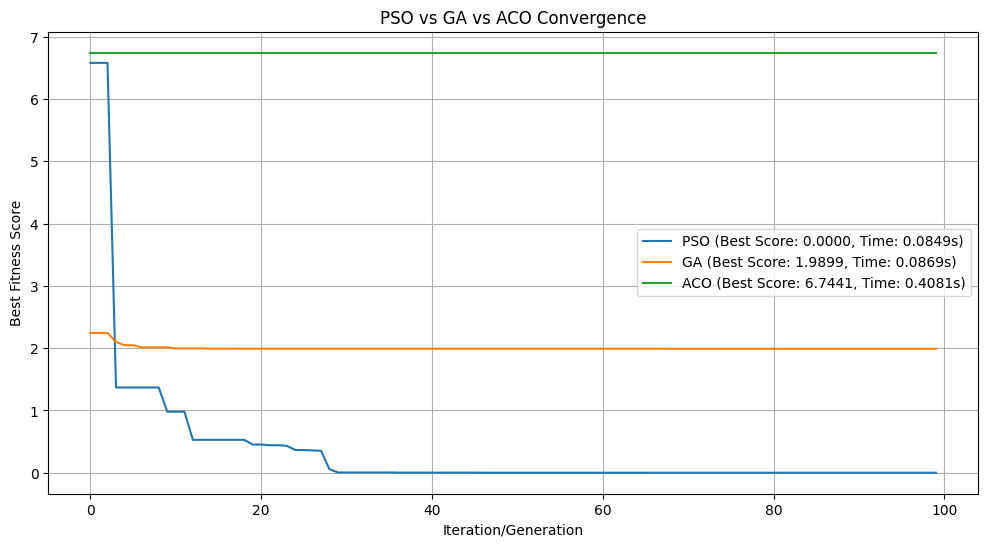

In [27]:
# Plot convergence
plt.figure(figsize=(12, 6))
plt.plot(pso_scores, label=f'PSO (Best Score: {pso_best_score:.4f}, Time: {end_time_pso - start_time_pso:.4f}s)')
plt.plot(ga_scores, label=f'GA (Best Score: {ga_best_score:.4f}, Time: {end_time_ga - start_time_ga:.4f}s)')
plt.plot(aco_scores, label=f'ACO (Best Score: {aco_best_score:.4f}, Time: {end_time_aco - start_time_aco:.4f}s)')
plt.title('PSO vs GA vs ACO Convergence')
plt.xlabel('Iteration/Generation')
plt.ylabel('Best Fitness Score')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Print the final best positions and scores
print(f"PSO Best Position: {pso_best_position}, Best Score: {pso_best_score}")
print(f"GA Best Position: {ga_best_position}, Best Score: {ga_best_score}")
print(f"ACO Best Position: {aco_best_position}, Best Score: {aco_best_score}")

PSO Best Position: [-4.80951502e-06 -5.71883646e-06], Best Score: 1.1077524675329187e-08
GA Best Position: [ 0.99499587 -0.99507224], Best Score: 1.9899209482316849
ACO Best Position: [ 0.88275862 -0.88275862], Best Score: 6.7440508134210315
